### Write a class with the following functions: 
- gp_model()
- set_initial_state()
- stim_state = sample()
- state_est = predict_state()
- transition_stete()


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [24]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)

        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        # U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        testX_shape_row, testX_shape_col = np.shape(testX)
        
        current_state = np.empty(())
        
        return current_state
        
    

In [25]:
model = state_dr_gp()

In [26]:
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [27]:
print(X0_psd, '\n',X1[0:4])

     sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]]


In [28]:
# input_data
U1_X0 = U1.join(X0_psd)

In [29]:
hill_sum_preStim_gamma = np.empty((100))
min_sum_preStim_gamma = np.min(U1_X0['sum_preStim_gamma'])
max_sum_preStim_gamma = np.max(U1_X0['sum_preStim_gamma'])
step_size = (max_sum_preStim_gamma-min_sum_preStim_gamma)/50
hill_sum_preStim_gamma[0:50] = np.arange(min_sum_preStim_gamma, max_sum_preStim_gamma, step_size)
hill_sum_preStim_gamma[50:100] = np.arange(max_sum_preStim_gamma,min_sum_preStim_gamma, -step_size)
print(hill_sum_preStim_gamma[0:3])

[0.81379952 1.01750611 1.22121269]


### Normal Basian Optimization: training a model and sampling

In [30]:
sampling_freq = np.empty((100))
sampling_freq[:] = 35
sampling_amp = np.empty((100))
sampling_amp[:] = 40
print(np.shape(sampling_freq), np.shape(sampling_amp))

(100,) (100,)


In [31]:
testX_BaO = np.array([sampling_freq, sampling_amp])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(testX_BaO[0:2, 0:1])
slice_dim = 1
ylabel='Predicted Gamma'

(2, 100)
[[35.]
 [40.]]


In [32]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x29c3beabf10>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x29c3b800df0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0004   1.812853e+03   1.486726e+04 
    00s18  0005   1.624593e+03   4.779714e+03 
    01s18  0034   1.115247e+03   6.434336e-10 
Runtime:     01s18
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x29c3c08d1f0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x29c3c0aacd0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x29c3c025fd0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x29c3bffc550>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x29c3bffc580>]}

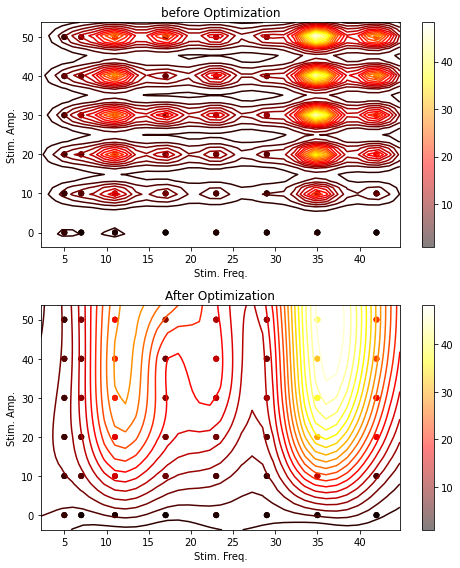

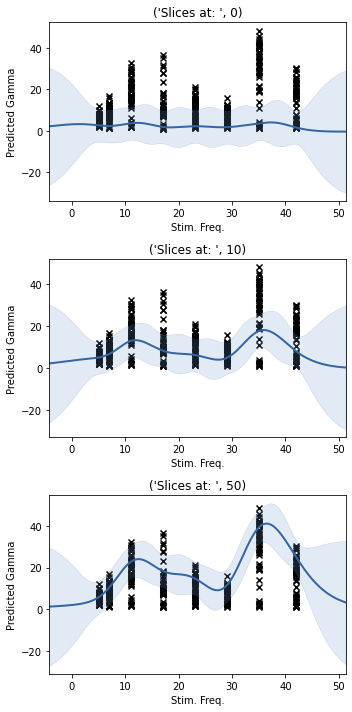

In [33]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

#### Sampling

In [34]:
state_est_BaO = np.empty((100, 30))
simY_BaO = np.empty((100, 30))
simMse_BaO = np.empty((100, 30))

for j in range(30):
    
    for i in range(99):
        # print(i)
        state_est_BaO[i:i+2, j], simY_BaO[i:i+2, j:j+1], simMse_BaO[i:i+2, j:j+1] = model.sample(testX_BaO, trained_model_BaO);

print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
# posteriorTestY
print(np.shape(state_est_BaO),'\n',state_est_BaO[0:10, 0])
print(np.shape(simY_BaO),'\n', np.shape(simMse_BaO))

mean is: 
 37.21769353528373 

 Variance is: 
 15.740497567909214
(100, 30) 
 [38.8866028  32.68171462 35.56252574 39.11956599 36.44379586 35.70860349
 35.97255049 34.91045481 37.9245452  31.63591499]
(100, 30) 
 (100, 30)


In [35]:
hill_state_est_BaO = np.empty((100, 30))
min_state_est_BaO = np.min(state_est_BaO,axis=0)
print(min_state_est_BaO[0])
max_state_est_BaO = np.max(state_est_BaO, axis=0)
print(max_state_est_BaO[0])
# step_size = np.round((max_posteriorTestY_BaO-min_posteriorTestY_BaO)/50,decimals=3)
print(step_size)
for i in range(30):
    hill_state_est_BaO[0:50,i] = np.linspace(min_state_est_BaO[i], max_state_est_BaO[i], 50)
    hill_state_est_BaO[50:100,i] = np.linspace(max_state_est_BaO[i],min_state_est_BaO[i], 50)
print(hill_state_est_BaO[0:50,1])

23.073064173349415
44.57065073553539
0.20370658621298587
[25.03745708 25.47711019 25.9167633  26.35641641 26.79606952 27.23572263
 27.67537574 28.11502885 28.55468196 28.99433507 29.43398818 29.87364129
 30.3132944  30.75294751 31.19260062 31.63225373 32.07190684 32.51155995
 32.95121306 33.39086617 33.83051929 34.2701724  34.70982551 35.14947862
 35.58913173 36.02878484 36.46843795 36.90809106 37.34774417 37.78739728
 38.22705039 38.6667035  39.10635661 39.54600972 39.98566283 40.42531594
 40.86496905 41.30462216 41.74427527 42.18392838 42.62358149 43.0632346
 43.50288771 43.94254082 44.38219393 44.82184704 45.26150015 45.70115326
 46.14080637 46.58045948]


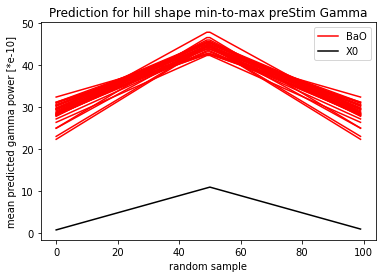

In [36]:
FIG, ax = plt.subplots()
a = plt.plot(hill_state_est_BaO, 'r-')
# plt.plot(simY_BaO[:, 0], 'b-')
# plt.plot(simY_BaO[:, 0] + simMse_BaO[:, 0]** 0.5, 'c--')
# plt.plot(simY_BaO[:, 0] - simMse_BaO[:, 0]** 0.5, 'c--')
b = plt.plot(hill_sum_preStim_gamma, 'k-')
plt.ylabel('mean predicted gamma power [*e-10]')
plt.xlabel('random sample')
plt.title('Prediction for hill shape min-to-max preStim Gamma')
plt.legend([a[0],b[0]],['BaO','X0']) #'Mean','+MSE', '-MSE', 
plt.show()

### State Dependent Basian Optimization: training a model and sampling

In [37]:
#GP model

# define kernel
kernel_SDBO = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(3)
slice_dim_SDBO = 2
ylabel_SDBO = 'Stim. Amp.'

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x29c349b09a0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x29c3486a490>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0005   1.681515e+03   6.342553e+03 
    01s15  0034   1.111442e+03   3.171993e-09 
Runtime:     01s15
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x29c38b348e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x29c389ec2e0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x29c3b27b5e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x29c3b272220>]}

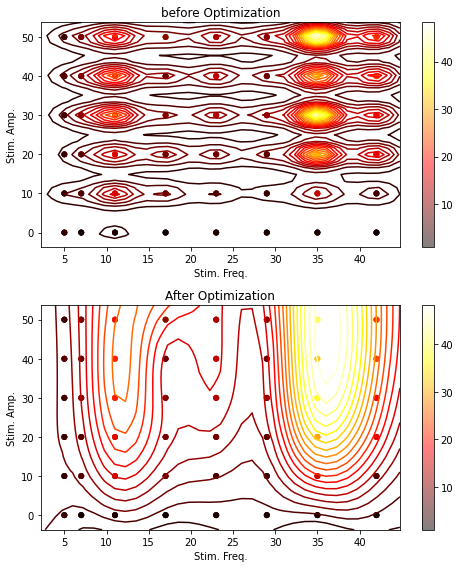

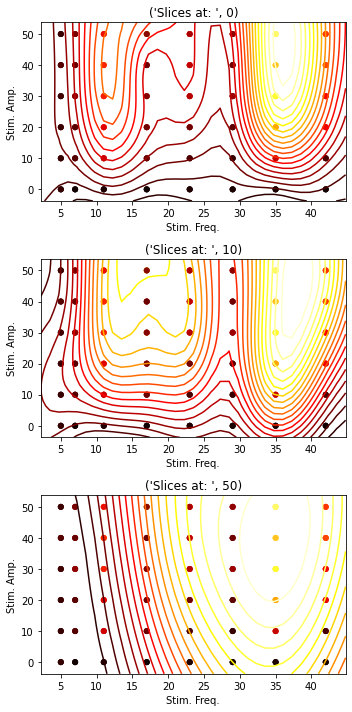

In [38]:
U1_X0, y, trained_model = model.initialize_data_dr_sim(U1_X0, X0_psd, X1, kernel_SDBO, slice_dim_SDBO, ylabel_SDBO)
# print(x)

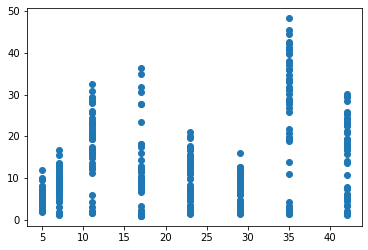

In [39]:
plt.scatter(U1_X0['Stim_1'],y)

In [40]:
testX = np.array([sampling_freq, sampling_amp, hill_sum_preStim_gamma])
print(np.shape(testX))
testX = np.transpose(testX)
print(testX[98:99,0:3])

(3, 100)
[[35.         40.          1.22121269]]


In [41]:
state_est_SDBO = np.empty((100, 30))
simY_SDBO = np.empty((100, 30))
simMse_SDBO = np.empty((100, 30))

for j in range(30):
    state_est_SDBO[:, j], simY_SDBO[:, j:j+1], simMse_SDBO[:, j:j+1] = model.sample(testX, trained_model);

posteriorTestY_SDBO, simY_SDBO, simMse_SDBO = model.sample(testX, trained_model)

In [42]:
print("mean is: \n",simY_SDBO[0,0],"\n\n Variance is: \n", simMse_SDBO[0, 0])
print(np.shape(state_est_SDBO),'\n',state_est_SDBO[0:10, 0])
print(np.shape(simY_SDBO),'\n', np.shape(simMse_SDBO))

mean is: 
 39.48027164845024 

 Variance is: 
 15.999478701702422
(100, 30) 
 [34.26738127 41.97104574 34.2987736  40.51716286 39.95817457 42.21008054
 38.9115647  36.79100511 42.06550439 36.05472351]
(100, 30) 
 (100, 30)


In [43]:
hill_state_est_SDBO = np.empty((100,30))
min_state_est_SDBO = np.min(state_est_SDBO, axis=0)
max_state_est_SDBO = np.max(state_est_SDBO, axis=0)
# step_size = (max_posteriorTestY_SDBO-min_posteriorTestY_SDBO)/50
for i in range(30):
    hill_state_est_SDBO[0:50, i] = np.linspace(min_state_est_SDBO[i], max_state_est_SDBO[i], 50)
    hill_state_est_SDBO[50:100, i] = np.linspace(max_state_est_SDBO[i],min_state_est_SDBO[i], 50)
print(hill_state_est_SDBO[0:3, 0])

[26.33099551 26.72896187 27.12692822]


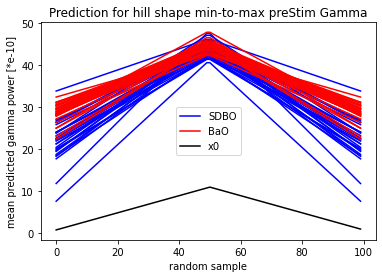

In [44]:
# plt.plot(posteriorTestY)
fig, ax = plt.subplots()
A = ax.plot(hill_state_est_SDBO, 'b-', label='SDBO')
# plt.legend(['SDBO'])
B = ax.plot(hill_state_est_BaO, 'r-', label='BaO')
# plt.legend(['BaO'])
# plt.plot(simY_SDBO[:, 0], 'b-')
# plt.plot(simY_SDBO[:, 0] + simMse_SDBO[:, 0]** 0.5, 'c--')
# plt.plot(simY_SDBO[:, 0] - simMse_SDBO[:, 0]** 0.5, 'c--')
C = ax.plot(hill_sum_preStim_gamma, 'k-', label='X0')
plt.ylabel('mean predicted gamma power [*e-10]')
plt.xlabel('random sample')
plt.title('Prediction for hill shape min-to-max preStim Gamma')
ax.legend([A[0], B[0], C[0]], ['SDBO', 'BaO', 'x0'])# 'Mean','+MSE', '-MSE', 
plt.show()